<a href="https://colab.research.google.com/github/snaily16/GAN-Implementations-Pytorch/blob/master/DCGAN/DeepConvolutionalGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network (DCGAN)

In [27]:
%matplotlib inline

import time
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from torchsummary import summary

## Download Anime Face Dataset from Kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list
!kaggle datasets download -d 'splcher/animefacedataset'

 96% 380M/395M [00:02<00:00, 119MB/s]
100% 395M/395M [00:03<00:00, 134MB/s]


In [ ]:
!mkdir animefacedataset
!unzip animefacedataset.zip -d animefacedataset

In [5]:
DATA_DIR = 'animefacedataset'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/images')[:5])

['images']
['56934_2017.jpg', '11805_2005.jpg', '40521_2012.jpg', '17951_2007.jpg', '11640_2005.jpg']


## Set Hyperparameters

In [6]:
# Hyperparameters
batch_size=128
num_epochs=25
image_size=64
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)
latent_size=128
lr = 0.0002

Load this dataset using `ImageFolder` 

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=transforms.Compose([
                  transforms.Resize(image_size),
                  transforms.CenterCrop(image_size),
                  transforms.ToTensor(),
                  transforms.Normalize(*stats)                                             
]))

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)

Helper function to -
* denormalize the image tensors
* show images from a training batch

In [8]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images,_ in dl:
    show_images(images,nmax)
    break

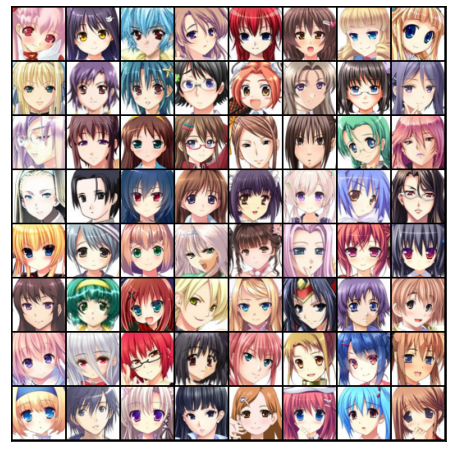

In [10]:
show_batch(train_loader)

In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Discriminator Network

In [12]:
D = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
D = D.to(device)
summary(D, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image

In [14]:
G = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    # out: 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    # out: 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # out: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # out: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),

    # out: 3 x 64 x 64
)

In [15]:
G = G.to(device)
summary(G, (latent_size,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

Random Noise generated by Generator

torch.Size([128, 3, 64, 64])


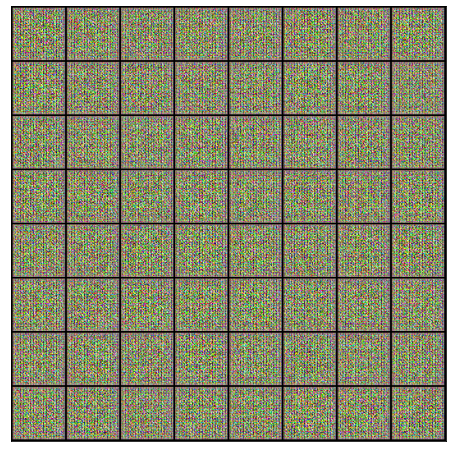

In [16]:
z=G(torch.randn(batch_size,latent_size, 1, 1))
print(z.shape)
show_images(z)

### Loss function and Optimizers

In [17]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

In [18]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def generate_latent():
  return torch.randn(batch_size,latent_size, 1, 1).to(device)

In [19]:
def train_discriminator(images):
  # create labels
  real_labels = torch.ones(images.size(0), 1).to(device)
  fake_labels = torch.zeros(images.size(0), 1).to(device)
    
  # ============================
  #   Train the discriminator
  # ============================

  # Compute BCELoss using real images
  # where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
  # Second term of the loss is always zero since real_labels == 1
  outputs = D(images)
  d_real_loss = criterion(outputs, real_labels)
  real_score = outputs

  # compute BCELoss using fake images
  # First term of the loss is always zero since fake_labels == 0
  latent = generate_latent()
  fake_images = G(latent)
  outputs = D(fake_images)
  d_fake_loss = criterion(outputs, fake_labels)
  fake_score = outputs

  # Backprop and optimize
  d_loss = d_real_loss + d_fake_loss
  reset_grad()
  d_loss.backward()
  d_optimizer.step()

  return d_loss, real_score, fake_score

In [23]:
def train_generator():
  real_labels = torch.ones(batch_size, 1).to(device)

  # ============================
  #    Train the Generator
  # ============================
    
  # compute loss with fake image
  latent = generate_latent()
  fake_images = G(latent)
  outputs = D(fake_images)

  # train G to maximize log(D(G(z)))
  g_loss = criterion(outputs, real_labels)

  # Backprop and optimize
  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  
  return g_loss, fake_images

In [21]:
directory = 'anime_dcgan'
if not os.path.exists(directory):
    os.mkdir(directory)

In [29]:
# Start Training
total_steps = len(train_loader)
d_losses, g_losses, real_scores, fake_scores =[],[],[],[]
for epoch in range(num_epochs):
  for n, (images, _) in enumerate(train_loader):
    #images = images.reshape(batch_size, -1).to(device)

    d_loss, real_score, fake_score = train_discriminator(images)
    g_loss, fake_images = train_generator()

    if n%100==0 or n==total_steps-1:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())
      print('Epoch [{}/{}], Step[{}/{}], d_loss: {}, g_loss: {}, D(x): {}, D(G(z)): {}'.format(
          epoch + 1, num_epochs, n+1, total_steps, d_loss.item(), g_loss.item(),
          real_score.data.mean().item(), fake_score.data.mean().item()))
      
    # Save real images
    if(epoch+1)==1:
      #images = images.reshape(images.size(0), 1, 28, 28)
      save_image(denorm(images), os.path.join(directory, 'real_images.png'),nrow=8)

    # Save sampled images
    if n==total_steps-1 or n==0:
      #fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
      save_image(denorm(fake_images), os.path.join(directory, 'fake_images-{}_{}.png'.format(epoch+1,n+1)), nrow=8)

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [1/25], Step[1/497], d_loss: 0.06783253699541092, g_loss: 6.828799724578857, D(x): 0.9521490335464478, D(G(z)): 0.001396790612488985
Epoch [1/25], Step[101/497], d_loss: 0.519568681716919, g_loss: 4.9764251708984375, D(x): 0.8514085412025452, D(G(z)): 0.24862244725227356
Epoch [1/25], Step[201/497], d_loss: 0.4131993055343628, g_loss: 5.2081499099731445, D(x): 0.8688098192214966, D(G(z)): 0.20688986778259277
Epoch [1/25], Step[301/497], d_loss: 0.5715444087982178, g_loss: 4.2714033126831055, D(x): 0.7591188549995422, D(G(z)): 0.21260233223438263
Epoch [1/25], Step[401/497], d_loss: 0.5517961382865906, g_loss: 4.827523231506348, D(x): 0.8441554307937622, D(G(z)): 0.2818247079849243


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([77, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


ValueError: ignored

Text(0.5, 1.0, 'Losses')

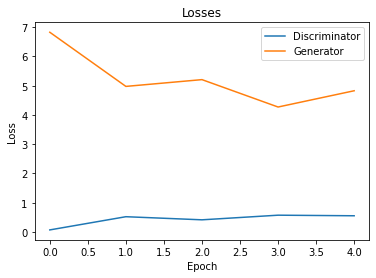

In [30]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

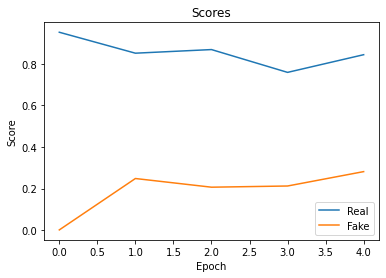

In [31]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

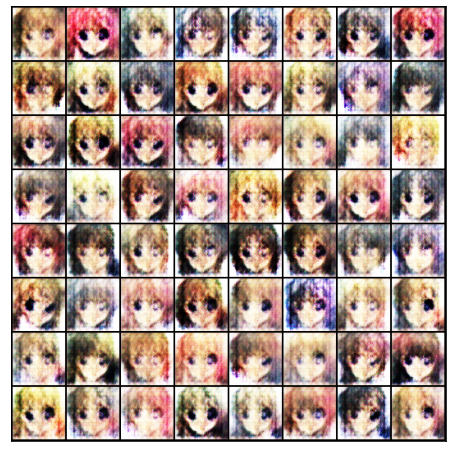

In [32]:
show_images(fake_images)